# COGS 108 - Final Project 

# Overview

This project seeks to find out whether there is a relationship or not between socio-economic class and the amount of restaurant violations that occur within zipcodes. By using a scatterplot and running the line of best fit through initially, we get an idea of how the relationship looks--a line with a small confidence interval suggests a strong relationship between the two variables. On the other hand, a line with a large confidence interval hints at a weak relationship between the two variables. By running an OLS regression, we can confirm whether our suspicions hold true or not.

# Name & PID

- Name: Stanley Xiao
- PID: A15435481

# Research Question

What violation will most restaurants have? Are those restaurants that have similar violations located in one particular zipcode? Does median family income play a role in the violations such that lower median income have more violations? 

## Background and Prior Work

While researching the topic on health inspections, I stumbled across how inspections are categorized in terms of risk. According to Forsyth County's website, there are four types of risk categories. Risk Category 1 refers to establishments, namely those that deal with food such as school cafeterias and restaurants, that are inspected once a year and "do not serve potentially hazardous foods" (1). Risk Category 2 refers to establishments that are inspected twice a year and have limited menu items with "simple food preparation procedures" (1). Risk Category 3 and 4 are to be inspected three and four times a year respectively (1 & 3). 

Additional interesting facts that I have found are that restaurants often fail to follow certain protocols that include the lack of gloves and hair protection, the lack of proper sanitation procedures, the lack of labeling open products, and most importantly, failing to store items on shelves and leaving them on the floor to name a few (3). Upon further research, I've learned that there are three different types of violations: priority, priority foundation, and core violations (4).

It should be mentioned that inspections are unannounced and are made by environmental health specialists (2).

References:
- 1) About the Inspection Process, www.forsyth.cc/PublicHealth/EnvironmentalHealth/aboutInspections.aspx.
- 2) Inspection Scores, https://www.rockinghamcountypublichealth.org/pview.aspx?id=20941&catid=0
- 3) M, Tina, and Philipa. “How to Prepare Your Bakery for a Health Department Inspection.” Cautiously Optimistic Kitchen, 27 Oct. 2017, cautiouslyoptimistickitchen.com/health-inspection/.
- 4) Violation Types, https://www.washtenaw.org/1562/Violation-Types#:~:text=The%20Priority%20Foundation%20category%20is,general%20sanitation%20and%20facility%20maintenance. 

# Hypothesis


I hypothesize that most restaurants will have violations that deal with sanitary issues. I believe that sanitary issues will not be ranged to one particular zipcode. I think these zipcodes will range across the state of North Carolina and that median family income will play a role in such violations such that lower than median family income will contain most of these restaurants that have violations. I think this due to the idea that smaller restaurants are often located in lower socioeconomic areas. These small restaurants are also abundant within the neighborhood. I also think that since these are small restaurants, they won't have the staff to properly maintain the place.

# Dataset(s)

- Dataset Name: Violations.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?download_frd=1
- Number of observations: 189802

Violations.csv is being used to find out what violations each restaurant has in the dataset. It will be used for its category section which states what policy the restaurant has violated and how severe it is, whether it is priority, priority foundation, or core. It has multiples of the same restaurants.

- Dataset Name: Inspections.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?download_frd=1
- Number of observations: 18466

Inspections.csv is being used mainly for its postal code. The csv file records the restaurant's name, address, when it was inspected, and by who. It has multiples of the same restaurants.

- Dataset Name: Zipcodes.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?download_frd=1
- Number of observations: 38

Zipcodes.csv is being used for its median family income in USD. The csv file states the demographics of the zipcode in terms of income and has percentages of those who are receiving benefits and those who are non-white.

- Dataset Name: Restaurants.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?download_frd=1
- Number of observations: 3324

Restaurants.csv is used to total the amount of restaurants within zipcodes so that we can measure violations by proportions.

I plan to combine these datasets by using the pd.merge() method. By merging violations.csv and inspections.csv, each restaurant now has a zip code. The product of this merge then undergoes another merge with the zipcodes.csv file so that each observation now has a corresponding median family income.


# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

In [2]:
#Read csvs
df_inspect = pd.read_csv("inspections.csv")
df_violations = pd.read_csv("violations.csv")
df_zip = pd.read_csv('zipcodes.csv')

In [3]:
#Keep the needed columns
df_inspect = df_inspect[['hsisid', 'postalcode']]
df_violations = df_violations[['hsisid', 'category', 'severity', 'pointvalue', 'comments']]
df_zip = df_zip[['zip', 'median_family_income_dollars']]

In [4]:
#Rename
df_zip.rename(columns = {'zip' : 'postalcode'}, inplace = True)

In [5]:
#Change zip's postalcode dtype
df_zip['postalcode'] = df_zip['postalcode'].apply(str)

In [6]:
#Merge and drop duplicates
df = pd.merge(df_inspect, df_violations, on = 'hsisid', how = 'right')
df = df.drop_duplicates(subset = 'hsisid', keep = 'last')
df = df.dropna()
df = df.reset_index(drop = True)
df = pd.merge(df, df_zip, on = 'postalcode')

In [7]:
#We no longer need hsisid
df = df.drop(labels = ['hsisid'], axis = 1)

In [20]:
#This will be the dataframe that we will be working with
df

,postalcode,category,severity,pointvalue,comments,median_family_income_dollars
0,27610,Chemical,Priority Foundation,1,One bottle labeled quat sanitizer bleached tes...,49213
1,27610,Utensils and Equipment,Core,0,4-602.13 Clean the build-up on the shelving lo...,49213
2,27610,Approved Source,Priority,0,"3-201.14; Priority; In the walk-in freezer, fi...",49213
3,27610,Chemical,Priority Foundation,0,7-102.11 . Label the sanitizer bottle.,49213
4,27610,Utensils and Equipment,Core,0,4-501.11; Core; Replace the torn gaskets on th...,49213
...,...,...,...,...,...,...
2226,27596,Utensils and Equipment,Core,1,4-501.11; Core; Repair the leak in the walk-in...,68750
2227,27596,Utensils and Equipment,Core,0,4-601.11(B) and (C); Core; Clean the shelves i...,68750
2228,27596,Utensils and Equipment,Core,0,4-602.13; Core; Clean the gaskets and shelves....,68750
2229,27501,Chemical,Priority Foundation,0,7-102.11; Priority Foundation; 1 bottle labele...,59408


# Data Analysis & Results

#### First, we will see what category has been violated the most. 

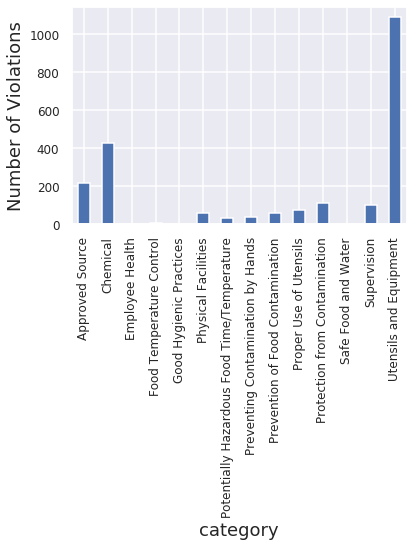

In [9]:
ax = df.groupby(['category']).size().plot.bar()
ax.set(ylabel = "Number of Violations")
ax.tick_params(labelsize = 12)

#### We see that Utensils and Equipment has the most amount of observations with 1090 violations.
#### Now, we will look at the comments section and see snippets of what was violated in Utensils and Equipment

In [10]:
df[df['category'] == "Utensils and Equipment"]

,postalcode,category,severity,pointvalue,comments,median_family_income_dollars
1,27610,Utensils and Equipment,Core,0,4-602.13 Clean the build-up on the shelving lo...,49213
4,27610,Utensils and Equipment,Core,0,4-501.11; Core; Replace the torn gaskets on th...,49213
9,27610,Utensils and Equipment,Core,0,4-602.13; Core; Clean the air returns in the e...,49213
12,27610,Utensils and Equipment,Priority Foundation,0,4-501.19; Priority Foundation; Dishes were bei...,49213
14,27610,Utensils and Equipment,Core,0,4-602.13 . Clean the walk-in cooler door gasket.,49213
...,...,...,...,...,...,...
2223,27520,Utensils and Equipment,Core,0,4-601.11(B) and (C); Core; General cleaning ar...,67939
2225,27520,Utensils and Equipment,Core,0,4-501.11 (B) . Replacement of torn cooler door...,67939
2226,27596,Utensils and Equipment,Core,1,4-501.11; Core; Repair the leak in the walk-in...,68750
2227,27596,Utensils and Equipment,Core,0,4-601.11(B) and (C); Core; Clean the shelves i...,68750


#### Looking at these 10 comments, we see that these violations are more towards maintenance and not necessarily sanitation issues, thereby proving my hypothesis wrong. 

#### From here, we will now see whether median household income will be a good predictor of the "Utensils and Equipment" violation.

In [11]:
y_1 = df[df['category'] == "Utensils and Equipment"].groupby('median_family_income_dollars').size()
x_1 = y_1.index
UnEdata = pd.DataFrame(data={'median income dollar': x_1, 'Utensils and Equipment Violations': y_1})

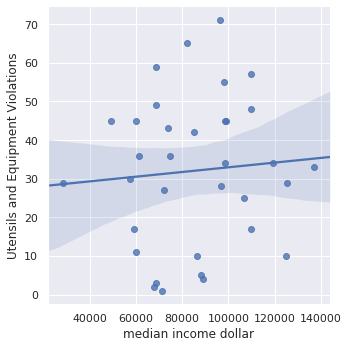

In [12]:
sns.set(font_scale = 1)
sns.lmplot(x='median income dollar', y = 'Utensils and Equipment Violations', data = UnEdata)

#### The slope is relatively flat, but that doesn't mean that it's not statistically different from zero. Setting up a hypothesis test, the null will be that beta_1, the slope, is zero, and the alternative hypothesis suggesting it is not equal to zero.

In [13]:
outcome, predictor = patsy.dmatrices('y_1~x_1', UnEdata)
mod = sm.OLS(outcome, predictor)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    y_1   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.1939
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.663
Time:                        00:02:14   Log-Likelihood:                -148.10
No. Observations:                  34   AIC:                             300.2
Df Residuals:                      32   BIC:                             303.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.8718     12.242      2.195      0.0

#### Because the t-statistic of 0.440 is less than 1.96, we fail to reject the null hypothesis that beta_1 is zero. The median family income dollars is not a good predictor of amount of restaurants violating "Utensils and Equipment". Is there a relationship between median family income dollars and violations in general?

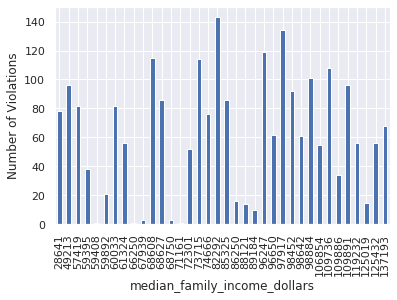

In [14]:
ax = df.groupby(['median_family_income_dollars']).size().plot.bar()
ax.set(ylabel = 'Number of Violations')
ax.tick_params(labelsize = 11)

#### Looking at the bar plot, we see that there is no relationship between median family income dollars and the number of violations.

In [15]:
y_2 = df.groupby('median_family_income_dollars').size()
x_2 = y_2.index
TotalData = pd.DataFrame({'Total Median Family Income Dollar' : x_2, 'Total Counts' : y_2})

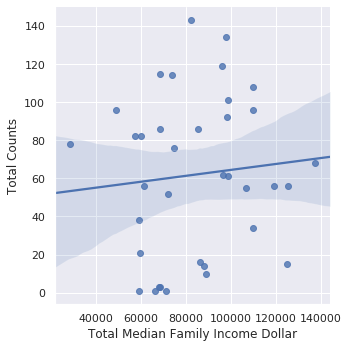

In [16]:
sns.set(font_scale = 1)
sns.lmplot(x = 'Total Median Family Income Dollar', y = 'Total Counts', data = TotalData)

#### Again, the graph produces a relatively flat slope, suggesting that there may not be a relationship between median family income and the number of violations. Setting up another hypothesis test, the null states that beta_1 is zero and the alternative states that it is not zero.

In [17]:
outcome_2, predictor_2 = patsy.dmatrices('y_2~x_2', TotalData)
mod_2 = sm.OLS(outcome_2, predictor_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    y_2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.2868
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.596
Time:                        00:02:15   Log-Likelihood:                -184.63
No. Observations:                  36   AIC:                             373.3
Df Residuals:                      34   BIC:                             376.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.8531     25.477      1.918      0.0

#### Because the t-statistic, 0.536, is smaller than 1.96, we fail to reject the null hypothesis and say that there is no relationship between median household income and restaurant violations. This should extend to zipcodes as well, such that if we were to plot them on a geopandas map of North Carolina, we would expect to see a random scatter of restaurants that has violations spread across the state. However, these results may not be accurate because the regression model states that there may be a strong multicollinearity. Because we're simply totaling the number of observations with respect to median family income, we can disregard the idea of multicollinearity.

# Ethics & Privacy

This project doesn't target any one specific restaurant or area so nothing can be used against these restaurants inspected. Restaurants already have to post health safety inspection scores already so consumers will already know whether the restaurants are good or bad. Additionally, nothing in this report can be traced back to the restaurants other than the datasets that have already been published to the public. The results have been generalized to zipcodes so readers cannot track the violations to specific restaurants unless they read through the raw datasets themselves. Therefore, I am strongly convinced that this report cannot be used to harm restaurants.

# Conclusion & Discussion

My project's goal is to merely see whether there is a relationship between violations and socio-economic class. The verdict of this project suggests that there is no significant relationship between median household income and restaurant violations. Restaurants in general have faced violations given by health inspectors, located in both higher socio-economic class and lower class areas. Without running geopandas, I can't say that these zipcodes are located within one specific region of North Carolina. I believe that it would be safe to assume that these restaurants are scattered across the states because there's no clear relationship between lower socio-economic classes and higher number of violations per what my hypothesis states. Additionally, it was not sanitation issues that were violated the most, but maintenance, further proving my hypothesis wrong. 

A limitation to my analysis was failing to use all of the data provided. Of the approximately 3300 restaurants, my analysis only covered 2200. Additionally, what if I were to use robust error terms? In my econometrics class, I was taught to always carry out regressions using robust standard errors that would capture the variance in error terms rather than have them remain static for every observation.